# Lives Saved Estimates with Python MINIMOD

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import minimod
from glob import glob
from pathlib import Path
import re
from functools import reduce
import gams
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from ipywidgets import fixed, interact, IntSlider


In [3]:
# Updated Costs and Lives Saved

update_folder = Path('Optimization Work', 'demewoz_lives_saved','data_files', 'updated_costs_lives_saved')

In [4]:
os.chdir("/home/lordflaron/Documents/minimod/")

## Processing Data

In [5]:
df_benefits_low = (
pd.read_excel(Path(update_folder, 'lives_saved_costs.xlsx'), 
sheet_name='lives_saved', 
skiprows=2)
.set_index(['intervention', 'region'])
.stack()
.reset_index()
.rename({0 : 'lives_saved', 'level_2' : 'time'}, axis=1)
)

df_benefits_high = (
pd.read_excel(Path(update_folder, 'lives_saved_costs.xlsx'), 
sheet_name='lives_saved_high', 
skiprows=2)
.set_index(['intervention', 'region'])
.stack()
.reset_index()
.rename({0 : 'lives_saved_high', 'level_2' : 'time'}, axis=1)
)

costs = (
pd.read_excel(Path(update_folder, 'lives_saved_costs.xlsx'), 
sheet_name='costs', 
skiprows=2)
.set_index(['intervention', 'region'])
.stack()
.reset_index()
.rename({0 : 'costs', 'level_2' : 'time'}, axis=1)
)

# Nope, load in Justin's data from GAMS
df_benefits_gams = (
pd.read_csv(Path(update_folder, 'lives_saved_low.csv'))
)

df_costs_gams = (
pd.read_csv(Path(update_folder, 'costs_low.csv'))
)


# Create function to make data adjustments
def observation_adjustment(data, int1, int2, time_to_replace, space_to_replace = slice(None)):
    
    df = data.copy(deep = True)

    if isinstance(int2, str):
        df_int2 = df.loc[(int2, space_to_replace, time_to_replace)]
        df.loc[(int1, space_to_replace, time_to_replace), :] = df_int2.values
    elif int2 == 0:
        df.loc[(int1, space_to_replace, time_to_replace), :] = 0

    print(f"Changed {int1} to {int2}")

    return df


In [6]:
# Create string function for going from GAMS code to python function

gams_str = """cov("cube",j,t2)=0                              ;
cov("cubezcube",j,t2)=0                         ;
cov("maxoilcube",j,t2)=cov("maxoil",j,t2) ;
cov("oilcube",j,t2)=cov("oil",j,t2)       ;
cov("oilcubevas",j,t2)=cov("oilvas",j,t2) ;
cov("maxoilcubevas",j,t2)=cov("maxoilvas",j,t2) ;
cov("cubevas",j,t2)=cov("vas",j,t2) ;
cov("cubeclinic",j,t2)=cov("clinic",j,t2) ;
cov("maxoilcubeclinic",j,t2)=cov("maxoilclinic",j,t2) ;
cov("oilcubeclinic",j,t2)=cov("oilclinic",j,t2) ;
cov("cubezflour",j,t2)=cov("zflour",j,t2) ;
cov("maxoilcubezflour",j,t2)=cov("maxoilzflour",j,t2) ;
cov("oilcubezflour",j,t2)=cov("oilzflour",j,t2) ;
cov("oilcubevaszflour",j,t2)=cov("oilvaszflour",j,t2) ;
cov("cubevaszflour",j,t2)=cov("vaszflour",j,t2) ;
cov("maxoilcubevaszflour",j,t2)=cov("maxoilvaszflour",j,t2) ;
cov("oilcubecliniczflour",j,t2)=cov("oilcliniczflour",j,t2) ;
cov("maxoilcubecliniczflour",j,t2)=cov("maxoilcliniczflour",j,t2) ;
cov("cubezflourzcube",j,t2)=cov("zflour",j,t2) ;
cov("maxoilcubezflourzcube",j,t2)=cov("maxoilzflour",j,t2) ;
cov("oilcubezflourzcube",j,t2)=cov("oilzflour",j,t2) ;
cov("oilcubevaszflourzcube",j,t2)=cov("oilvaszflour",j,t2) ;
cov("oilcubecliniczflourzcube",j,t2)=cov("oilcliniczflour",j,t2) ;
cov("maxoilcubecliniczflourzcube",j,t2)=cov("maxoilcliniczflour",j,t2) ;

cov("zcube",j,t2)=0                      ;
cov("zflourzcube",j,t2)=cov("zflour",j,t2) ;
cov("oilvaszflourzcube",j,t2)=cov("oilvaszflour",j,t2) ;
cov("maxoilcubezflourzcube",j,t2)=cov("maxoilzflour",j,t2) ;
cov("oilzflourzcube",j,t2)=cov("oilzflour",j,t2) ;

cov("oilzflourfcubefflour",j,t2)=cov("oilzflourfflour",j,t2) ;
cov("maxoil",j,t4)=cov("oil",j,t4) ;
cov("maxoilcube",j,t4)=cov("oilcube",j,t4) ;
cov("maxoilvas",j,t4)=cov("oilvas",j,t4) ;
cov("maxoilcubevas",j,t4)=cov("oilcubevas",j,t4) ;
cov("maxoilclinic",j,t4)=cov("oilclinic",j,t4) ;
cov("maxoilcubeclinic",j,t4)=cov("oilcubeclinic",j,t4) ;
cov("maxoilzflour",j,t4)=cov("oilzflour",j,t4) ;
cov("maxoilcubezflour",j,t4)=cov("oilcubezflour",j,t4) ;
cov("maxoilvaszflour",j,t4)=cov("oilvaszflour",j,t4) ;
cov("maxoilcliniczflour",j,t4)=cov("oilcliniczflour",j,t4) ;
cov("maxoilcubevaszflour",j,t4)=cov("oilcubevaszflour",j,t4) ;
cov("maxoilcubecliniczflour",j,t4)=cov("oilcubecliniczflour",j,t4) ;
cov("maxoilzflourzcube",j,t4)=cov("oilzflourzcube",j,t4) ;
cov("maxoilcubezflourzcube",j,t4)=cov("oilcubezflourzcube",j,t4) ;
cov("maxoilvaszflourzcube",j,t4)=cov("oilvaszflourzcube",j,t4) ;
cov("maxoilcliniczflourzcube",j,t4)=cov("oilcliniczflourzcube",j,t4) ;
cov("maxoilcubevaszflourzcube",j,t4)=cov("oilcubevaszflourzcube",j,t4) ;
cov("maxoilcubecliniczflourzcube",j,t4)=cov("oilcubecliniczflourzcube",j,t4) ;
cov("zflourfflour33",j,t)=0;
cov("fflour33",j,t)=0;"""

In [7]:
a = [x.strip() for x in gams_str.split(';')]

for i in a:

    cov_str = re.compile(r'(?<=cov\()(\"[a-z0-9]+\")')
    time_str = re.compile(r't[24]*')

    found = cov_str.findall(i)
    time_found = time_str.findall(i)
    # print(time_found)
    if time_found[0] == 't2':
        time_range = '[1,2,3]'
    elif time_found[0] == 't4':
        time_range = '[1,2]'
    elif time_found[0] == 't':
        time_range = 'slice(None)'
    elif not time_found:
        print("not found time")
        continue

    if len(found) == 2:
        second_int = found[1]
    elif not found:
        print("not found")
    else:
        second_int = 0

    # print(found, time_range)
    print(f""".pipe(observation_adjustment,\nint1 = {found[0]},\nint2 = {second_int},\ntime_to_replace = {time_range})""")



.pipe(observation_adjustment,
int1 = "cube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubezcube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcube",
int2 = "maxoil",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcube",
int2 = "oil",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubevas",
int2 = "oilvas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubevas",
int2 = "maxoilvas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubevas",
int2 = "vas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubeclinic",
int2 = "clinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubeclinic",
int2 = "maxoilclinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubeclinic",
int2 = "oilclinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubezflour",
int2 = "

IndexError: list index out of range

In [8]:
df_benefits_low_adjusted = (df_benefits_low.set_index(['intervention', 'region', 'time'])
.pipe(observation_adjustment,
int1 = "cube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubezcube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcube",
int2 = "maxoil",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcube",
int2 = "oil",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubevas",
int2 = "oilvas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubevas",
int2 = "maxoilvas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubevas",
int2 = "vas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubeclinic",
int2 = "clinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubeclinic",
int2 = "maxoilclinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubeclinic",
int2 = "oilclinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubezflour",
int2 = "zflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubezflour",
int2 = "maxoilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubezflour",
int2 = "oilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubevaszflour",
int2 = "oilvaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubevaszflour",
int2 = "vaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubevaszflour",
int2 = "maxoilvaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubecliniczflour",
int2 = "oilcliniczflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubecliniczflour",
int2 = "maxoilcliniczflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubezflourzcube",
int2 = "zflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubezflourzcube",
int2 = "maxoilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubezflourzcube",
int2 = "oilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubevaszflourzcube",
int2 = "oilvaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubecliniczflourzcube",
int2 = "oilcliniczflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubecliniczflourzcube",
int2 = "maxoilcliniczflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "zcube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "zflourzcube",
int2 = "zflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilvaszflourzcube",
int2 = "oilvaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubezflourzcube",
int2 = "maxoilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilzflourzcube",
int2 = "oilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilzflourfcubefflour",
int2 = "oilzflourfflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoil",
int2 = "oil",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcube",
int2 = "oilcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilvas",
int2 = "oilvas",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubevas",
int2 = "oilcubevas",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilclinic",
int2 = "oilclinic",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubeclinic",
int2 = "oilcubeclinic",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilzflour",
int2 = "oilzflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubezflour",
int2 = "oilcubezflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilvaszflour",
int2 = "oilvaszflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcliniczflour",
int2 = "oilcliniczflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubevaszflour",
int2 = "oilcubevaszflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubecliniczflour",
int2 = "oilcubecliniczflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilzflourzcube",
int2 = "oilzflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubezflourzcube",
int2 = "oilcubezflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilvaszflourzcube",
int2 = "oilvaszflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcliniczflourzcube",
int2 = "oilcliniczflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubevaszflourzcube",
int2 = "oilcubevaszflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubecliniczflourzcube",
int2 = "oilcubecliniczflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "zflourfflour33",
int2 = 0,
time_to_replace = slice(None))
.pipe(observation_adjustment,
int1 = "fflour33",
int2 = 0,
time_to_replace = slice(None)))


Changed cube to 0
Changed cubezcube to 0
Changed maxoilcube to maxoil
Changed oilcube to oil
Changed oilcubevas to oilvas
Changed maxoilcubevas to maxoilvas
Changed cubevas to vas
Changed cubeclinic to clinic
Changed maxoilcubeclinic to maxoilclinic
Changed oilcubeclinic to oilclinic
Changed cubezflour to zflour
Changed maxoilcubezflour to maxoilzflour
Changed oilcubezflour to oilzflour
Changed oilcubevaszflour to oilvaszflour
Changed cubevaszflour to vaszflour
Changed maxoilcubevaszflour to maxoilvaszflour
Changed oilcubecliniczflour to oilcliniczflour
Changed maxoilcubecliniczflour to maxoilcliniczflour
Changed cubezflourzcube to zflour
Changed maxoilcubezflourzcube to maxoilzflour
Changed oilcubezflourzcube to oilzflour
Changed oilcubevaszflourzcube to oilvaszflour
Changed oilcubecliniczflourzcube to oilcliniczflour
Changed maxoilcubecliniczflourzcube to maxoilcliniczflour
Changed zcube to 0
Changed zflourzcube to zflour
Changed oilvaszflourzcube to oilvaszflour
Changed maxoilcubezf

In [9]:
df_benefits_high_adjusted = (df_benefits_high.set_index(['intervention', 'region', 'time'])
.pipe(observation_adjustment,
int1 = "cube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubezcube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcube",
int2 = "maxoil",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcube",
int2 = "oil",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubevas",
int2 = "oilvas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubevas",
int2 = "maxoilvas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubevas",
int2 = "vas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubeclinic",
int2 = "clinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubeclinic",
int2 = "maxoilclinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubeclinic",
int2 = "oilclinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubezflour",
int2 = "zflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubezflour",
int2 = "maxoilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubezflour",
int2 = "oilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubevaszflour",
int2 = "oilvaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubevaszflour",
int2 = "vaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubevaszflour",
int2 = "maxoilvaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubecliniczflour",
int2 = "oilcliniczflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubecliniczflour",
int2 = "maxoilcliniczflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubezflourzcube",
int2 = "zflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubezflourzcube",
int2 = "maxoilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubezflourzcube",
int2 = "oilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubevaszflourzcube",
int2 = "oilvaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubecliniczflourzcube",
int2 = "oilcliniczflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubecliniczflourzcube",
int2 = "maxoilcliniczflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "zcube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "zflourzcube",
int2 = "zflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilvaszflourzcube",
int2 = "oilvaszflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubezflourzcube",
int2 = "maxoilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilzflourzcube",
int2 = "oilzflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilzflourfcubefflour",
int2 = "oilzflourfflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoil",
int2 = "oil",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcube",
int2 = "oilcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilvas",
int2 = "oilvas",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubevas",
int2 = "oilcubevas",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilclinic",
int2 = "oilclinic",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubeclinic",
int2 = "oilcubeclinic",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilzflour",
int2 = "oilzflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubezflour",
int2 = "oilcubezflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilvaszflour",
int2 = "oilvaszflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcliniczflour",
int2 = "oilcliniczflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubevaszflour",
int2 = "oilcubevaszflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubecliniczflour",
int2 = "oilcubecliniczflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilzflourzcube",
int2 = "oilzflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubezflourzcube",
int2 = "oilcubezflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilvaszflourzcube",
int2 = "oilvaszflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcliniczflourzcube",
int2 = "oilcliniczflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubevaszflourzcube",
int2 = "oilcubevaszflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubecliniczflourzcube",
int2 = "oilcubecliniczflourzcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "zflourfflour33",
int2 = 0,
time_to_replace = slice(None))
.pipe(observation_adjustment,
int1 = "fflour33",
int2 = 0,
time_to_replace = slice(None))
.pipe(observation_adjustment,
int1 = "cubezflourzcubefcubefflour",
int2 = "zflourfflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubezflourfcubefflour",
int2 = "zflourfflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilzflourzcubefcubefflour",
int2 = "oilzflourfflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "fcube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "fcube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilfcube",
int2 = 'oil',
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubeclinicfcube",
int2 = 'oilclinic',
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilzflourfcubefflour",
int2 = 'maxoilzflourfflour',
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcliniczflourfcubefflour",
int2 = "maxoilcliniczflourfflour",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilzflourfcubefflour",
int2 = "oilzflourfcubefflour",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcliniczflourfcubefflour",
int2 = "oilcliniczflourfcubefflour",
time_to_replace = [1,2])
)


Changed cube to 0
Changed cubezcube to 0
Changed maxoilcube to maxoil
Changed oilcube to oil
Changed oilcubevas to oilvas
Changed maxoilcubevas to maxoilvas
Changed cubevas to vas
Changed cubeclinic to clinic
Changed maxoilcubeclinic to maxoilclinic
Changed oilcubeclinic to oilclinic
Changed cubezflour to zflour
Changed maxoilcubezflour to maxoilzflour
Changed oilcubezflour to oilzflour
Changed oilcubevaszflour to oilvaszflour
Changed cubevaszflour to vaszflour
Changed maxoilcubevaszflour to maxoilvaszflour
Changed oilcubecliniczflour to oilcliniczflour
Changed maxoilcubecliniczflour to maxoilcliniczflour
Changed cubezflourzcube to zflour
Changed maxoilcubezflourzcube to maxoilzflour
Changed oilcubezflourzcube to oilzflour
Changed oilcubevaszflourzcube to oilvaszflour
Changed oilcubecliniczflourzcube to oilcliniczflour
Changed maxoilcubecliniczflourzcube to maxoilcliniczflour
Changed zcube to 0
Changed zflourzcube to zflour
Changed oilvaszflourzcube to oilvaszflour
Changed maxoilcubezf

In [10]:
# Merge data
df = (
df_benefits_low_adjusted
.merge(df_benefits_high_adjusted, on = ['intervention', 'region', 'time'])
.merge(costs, on = ['intervention', 'region', 'time'])
.assign(lives_saved = lambda df: df['lives_saved'].astype(int),
lives_saved_high = lambda df: df['lives_saved_high'].astype(int),
costs = lambda df: df['costs'].astype(int))
)

df_gams = (
df_benefits_gams
.merge(df_costs_gams, on = ['intervention', 'space', 'time'])
)




## Summary Statistics

Now we show some summary statistics of the data

### Lives Saved

In [11]:
s = minimod.utils.summary.PreOptimizationDataSummary(
    data = df,
    benefit_col= 'lives_saved',
    cost_col= 'costs',
    intervention_col='intervention',
    space_col= 'region',
    time_col='time',
    benefit_title='Lives Saved (Low)',
    intervention_subset=['clinic', 'vas','zflour', 'fflour', 'cube', 'fcube'],
    intervention_subset_titles={'clinic' : 'VAS Clinic Day', 
    'vas' : 'Vitamin A Supp.', 
    'zflour' : 'Zinc Flour',
    'fflour' : 'Folic Acid Flour' ,
    'cube' : 'Boullion Cube',
    'fcube' : 'Boullion Cube with Folic Acid',
    'oilvaszflourfflour33' : 'BAU: Oil/VAS/Flour with Zinc and Folic Acid (33%)'},
    bau_intervention = 'oilvaszflourfflour33'
)

s.summary_table(variables_of_interest= {'Cost per Child ($)' : 'cost_per_benefit'}, grouping = 'over_space', style = 'markdown')


,Intervention,Regions,Lives Saved (Low),Costs ($),Cost per Child ($)
2,VAS Clinic Day,North,"1,752","2,865,441",1635.530000
3,VAS Clinic Day,South,855,"3,841,014",4492.410000
0,VAS Clinic Day,Cities,413,"1,122,789",2718.620000
1,VAS Clinic Day,National,"3,020","7,829,244",2592.460000
22,Vitamin A Supp.,North,"10,886","10,255,671",942.100000
23,Vitamin A Supp.,South,"5,756","13,732,662",2385.800000
20,Vitamin A Supp.,Cities,"2,819","5,679,743",2014.810000
21,Vitamin A Supp.,National,"19,461","29,668,076",1524.490000
26,Zinc Flour,North,"3,365","1,433,316",425.950000
27,Zinc Flour,South,"3,353","2,266,593",675.990000


### Lives Saved High

In [12]:
s = minimod.utils.summary.PreOptimizationDataSummary(
    data = df,
    benefit_col= 'lives_saved_high',
    cost_col= 'costs',
    intervention_col='intervention',
    space_col= 'region',
    time_col='time',
    benefit_title='Lives Saved (High)',
    intervention_subset=['clinic', 'vas','zflour', 'fflour', 'cube', 'fcube'],
    intervention_subset_titles={'clinic' : 'VAS Clinic Day', 
    'vas' : 'Vitamin A Supp.', 
    'zflour' : 'Zinc Flour',
    'fflour' : 'Folic Acid Flour' ,
    'cube' : 'Boullion Cube',
    'fcube' : 'Boullion Cube with Folic Acid',
    'oilvaszflourfflour33' : 'BAU: Oil/VAS/Flour with Zinc and Folic Acid (33%)'},
    bau_intervention = 'oilvaszflourfflour33'
)

s.summary_table(variables_of_interest= {'Cost per Child ($)' : 'cost_per_benefit'}, grouping = 'over_space', style = 'markdown')

,Intervention,Regions,Lives Saved (High),Costs ($),Cost per Child ($)
2,VAS Clinic Day,North,"2,321","2,865,441",1234.570000
3,VAS Clinic Day,South,"1,095","3,841,014",3507.780000
0,VAS Clinic Day,Cities,539,"1,122,789",2083.100000
1,VAS Clinic Day,National,"3,955","7,829,244",1979.580000
22,Vitamin A Supp.,North,"14,410","10,255,671",711.710000
23,Vitamin A Supp.,South,"7,368","13,732,662",1863.820000
20,Vitamin A Supp.,Cities,"3,693","5,679,743",1537.980000
21,Vitamin A Supp.,National,"25,471","29,668,076",1164.780000
26,Zinc Flour,North,"3,365","1,433,316",425.950000
27,Zinc Flour,South,"3,353","2,266,593",675.990000


## Run MINIMOD

In [13]:
 cubek = ['cube',   'maxoilcube', 'cubezflourfflour',  'cubefcube', 'cubezcubefcube', 'maxoilcubefcube',  'oilcubefflour',
           'oilcube', 'oilcubevas', 'maxoilcubevas', 'cubevas', 'cubeclinic', 'oilcubeclinic', 'cubezflourfcube', 'maxoilcubezflourfcubefflour',
           'maxoilcubeclinic', 'cubezflour', 'maxoilcubezflour', 'oilcubezflour', 'oilcubevaszflour', 'oilcubefcube', 'maxoilcubezflourzcubefcube',
           'cubevaszflour', 'maxoilcubevaszflour', 'cubefcubefflour', 'cubezcubefcubefflour', 'cubecliniczflourzcubefcubefflour',
          'cubezflourzcube', 'maxoilcubezflourzcube', 'oilcubezflourzcube', 'oilcubevaszflourzcube',   'cubecliniczflourfcubefflour',
          'cubevaszflourzcube', 'maxoilcubevaszflourzcube',  'maxoilcubezflourfflour', 'cubecliniczflourzcubefcube', 'cubevaszflourzcubefcube',
           'oilcubezflourfflour', 'cubezflourzcubefflour', 'cubecliniczflourzcubefflour', 'cubecliniczflourfcube', 'cubevaszflourzcubefcubefflour',
           'maxoilcubefflour', 'cubeclinicfcube', 'maxoilcubezflourzcubefcubefflour', 'oilcubezflourfcubefflour', 'maxoilcubezflourfcube',
           'cubevasfcube', 'maxoilcubefcubefflour', 'cubecliniczflourfflour', 'cubevaszflourfcube', 'cubevaszflourfcubefflour', 'oilcubefcubefflour',
           'cubezflourfcubefflour', 'cubevaszflourzcubefflour', 'cubevasfcubefflour', 'cubezflourzcubefcubefflour'  ]

 zcubek = ['zcube', 'zflourzcube', 'cubezcube', 'cubezflourzcube', 'oilvaszflourzcube', 'maxoilcubezflourzcube', 'zcubefcube',
            'oilzflourzcube', 'oilcubezflourzcube', 'oilcubevaszflourzcube', 'maxoilzflourzcube', 'maxoilvaszflourzcube', 'zflourzcubefcube',
            'vaszflourzcube', 'cubevaszflourzcube', 'maxoilcubevaszflourzcube', 'zflourzcubefcubefflour']

 fcubek = ['fcube', 'oilfcube', 'cubezflourzcubefcubefflour', 'cubezflourzcubefcube', 'cubezflourfcubefflour', 'maxoilfcube', 'maxoilcubezflourfcube', 'maxoilfcubefflour',
            'maxoilzflourzcubefcube', 'oilzflourfcubefflour'   ]

 oilk = ['oilvas', 'oil', 'oilcube', 'oilcubevas', 'oilclinic',    'oilcubeclinic', 'oilvaszflour', 'oilzflour', 'oilzflourfflour', 'oilcubecliniczflourfflour', 'oilcubezflourzcubefflour',
          'oilcliniczflour', 'oilcubezflour', 'oilcubevaszflour', 'oilcubecliniczflour', 'oilvaszflourzcube', 'oilfcube', 'oilcubezflourzcubefcube', 'oilcubezflourfcube', 'oilcubezflourfcubefflour',
          'oilzflourzcube',    'oilcliniczflourzcube', 'oilcubezflourzcube',  'oilcubevaszflourzcube', 'oilcubecliniczflourzcube', 'oilcubezflourzcubefcubefflour',
          'oilcubefcubefflour', 'oilzflourfcubefflour', 'oilcubecliniczflourzcubefcubefflour', 'oilcubeclinicfcube',  'oilzflourzcubefcubefflour', 'oilcubecliniczflourzcubefcube',
          'oilzflourzcubefcube', 'oilcubecliniczflourfcube', 'oilcubecliniczflourfcubefflour', 'oilcubecliniczflourzcubefflour', 'oilzflourfcube', 'oilfcubefflour',
          'oilcubeclinicfcubefflour', 'oilcliniczflourfcubefflour', 'oilcubevaszflourzcubefcubefflour', 'oilcubeclinicfflour', 'oilzflourzcubefflour', 'oilcubevasfcube',
          'oilcubevaszflourzcubefcube', 'oilvaszflourfcubefflour', 'oilcubevaszflourfcube', 'oilcliniczflourzcubefcube', 'oilvasfcubefflour', 'oilcubevaszflourfcubefflour',
          'oilcliniczflourfflour', 'oilcubevaszflourzcubefflour'    ]

 maxoilk = ['maxoil', 'maxoilcube', 'maxoilvas', 'maxoilcubevas' ,  'maxoilclinic', 'maxoilcubeclinic' ,  'maxoilzflour', 'maxoilcubezflourzcubefcube', 'maxoilzflourfcubefflour',
             'maxoilcubezflour' ,    'maxoilvaszflour' ,    'maxoilcliniczflour', 'maxoilcubevaszflour'  ,    'maxoilcubecliniczflour', 'maxoilcubefcubefflour',
             'maxoilzflourzcube'   ,   'maxoilcubezflourzcube', 'maxoilvaszflourzcube' ,   'maxoilcubezflourzcubefcubefflour', 'maxoilcubezflourfcubefflour',
              'maxoilcliniczflourzcube'    ,    'maxoilcubevaszflourzcube', 'maxoilcubecliniczflourzcube', 'maxoilcubezflourfcube', 'maxoilcubecliniczflourzcubefcubefflour',
            'maxoilcubezflourzcubefflour', 'maxoilcubecliniczflourzcubefcube', 'maxoilcubeclinicfcube', 'maxoilzflourzcubefcubefflour', 'maxoilzflourzcubefcube',
            'maxoilcubecliniczflourfcubefflour', 'maxoilzflourfflour', 'maxoilcubecliniczflourfcube', 'maxoilzflourfcube', 'maxoilcubecliniczflourzcubefflour', 'maxoilzflourzcubefflour',
            'maxoilfcubefflour', 'maxoilcubeclinicfcubefflour', 'maxoilcliniczflourfcubefflour', 'maxoilcubeclinicfflour', 'maxoilfcube', 'maxoilcubevaszflourzcubefcubefflour',
           'maxoilcubevaszflourzcubefcube', 'maxoilcliniczflourzcubefcube', 'maxoilcliniczflourzcubefcubefflour', 'maxoilcubevasfcube', 'maxoilcubecliniczflourfflour' ]

 zflourk = ['zflour', 'zflourzcube',    'cubezflour', 'oilvaszflour', 'maxoilzflour', 'maxoilcubezflour', 'oilzflour',  'zflourfcube' , 'zflourzcubefcubefflour',
            'oilcliniczflour', 'oilcubezflour', 'oilcubevaszflour' ,    'maxoilvaszflour', 'vaszflour' , 'cliniczflour', 'cliniczflourfflour', 'oilzflourfflour',
            'cubevaszflour',  'maxoilcliniczflour', 'maxoilcubevaszflour' , 'oilcubecliniczflourfflour', 'zflourfflour',  'oilzflourfcubefflour', 'oilzflourfcube',
            'cubezflourzcube',   'oilvaszflourzcube', 'maxoilzflourzcube',    'maxoilcubezflourzcube', 'oilzflourzcube',  'maxoilcubecliniczflourfflour', 'maxoilzflourfcubefflour',
            'oilcubezflourzcube' ,    'oilcubevaszflourzcube', 'maxoilvaszflourzcube', 'vaszflourzcube',  'cubevaszflourzcube'    ,    'maxoilcubevaszflourzcube',
           'maxoilzflourfflour', 'oilzflourzcubefcubefflour', 'zflourfcubefflour', 'zflourzcubefflour', 'maxoilzflourfcube', 'oilzflourzcubefcube', 'oilcliniczflourfcubefflour',
            'oilcubezflourzcubefcubefflour']

 fflourk = ['fflour', 'oilzflourfflour', 'zflourfflour', 'oilfcubefflour' ]

 flouronlyk = ['zflour',  'oilvaszflour', 'maxoilzflour', 'oilzflour',
            'oilcliniczflour',     'maxoilvaszflour', 'vaszflour' , 'cliniczflour',
             'maxoilcliniczflour' ]

 cubeonlyk = ['cube',   'maxoilcube',
           'oilcube', 'oilcubevas', 'maxoilcubevas', 'cubevas', 'cubeclinic', 'oilcubeclinic',
           'maxoilcubeclinic']

 flourcubek = ['zflourzcube',    'cubezflour', 'maxoilcubezflour',
            'oilcubezflour', 'oilcubevaszflour' ,
            'cubevaszflour', 'maxoilcubevaszflour' ,
            'cubezflourzcube',   'oilvaszflourzcube', 'maxoilzflourzcube',    'maxoilcubezflourzcube', 'oilzflourzcube', 'oilcliniczflourzcube',
            'oilcubezflourzcube' ,    'oilcubevaszflourzcube', 'maxoilvaszflourzcube', 'vaszflourzcube', 'cliniczflourzcube', 'cubevaszflourzcube',
          'maxoilcubevaszflourzcube'     ]

In [14]:
# Do the same for the High Lives Saved numbers
cubek_high = ['cube',   'maxoilcube', 'cubezflourfflour',  'cubefcube', 'cubezcubefcube', 'maxoilcubefcube',  'oilcubefflour',
           'oilcube', 'oilcubevas', 'maxoilcubevas', 'cubevas', 'cubeclinic', 'oilcubeclinic', 'cubezflourfcube','maxoilcubezflourfcubefflour',
           'maxoilcubeclinic', 'cubezflour', 'maxoilcubezflour', 'oilcubezflour', 'oilcubevaszflour', 'oilcubefcube', 'maxoilcubezflourzcubefcube',
           'cubevaszflour', 'maxoilcubevaszflour', 'cubefcubefflour', 'cubezcubefcubefflour', 'cubecliniczflourzcubefcubefflour',
          'cubezflourzcube', 'maxoilcubezflourzcube', 'oilcubezflourzcube', 'oilcubevaszflourzcube',   'cubecliniczflourfcubefflour',
          'cubevaszflourzcube', 'maxoilcubevaszflourzcube',  'maxoilcubezflourfflour', 'cubecliniczflourzcubefcube', 'cubevaszflourzcubefcube',
           'oilcubezflourfflour', 'cubezflourzcubefflour', 'cubecliniczflourzcubefflour', 'cubecliniczflourfcube', 'cubevaszflourzcubefcubefflour',
           'maxoilcubefflour', 'cubeclinicfcube', 'maxoilcubezflourzcubefcubefflour', 'oilcubezflourfcubefflour', 'maxoilcubezflourfcube',
           'cubevasfcube', 'maxoilcubefcubefflour', 'cubecliniczflourfflour', 'cubevaszflourfcube', 'cubevaszflourfcubefflour', 'oilcubefcubefflour',
           'cubezflourfcubefflour', 'cubevaszflourzcubefflour', 'cubevasfcubefflour', 'cubezflourzcubefcubefflour', 'oilcubezflourzcubefcubefflour',
           'oilcubezflourfcube', "maxoilcubecliniczflourfflour", "oilcubecliniczflourfcubefflour", "oilcubecliniczflourzcubefcubefflour",
           "maxoilcubecliniczflourzcubefcube", "maxoilcubeclinicfcube", "oilcubecliniczflourfflour", "maxoilcubecliniczflourfcubefflour",
           "maxoilcubecliniczflourzcubefflour", "maxoilcubeclinicfcubefflour", "oilcubeclinicfcube", "oilcubecliniczflourfcube", "oilcubeclinicfcubefflour"  ]

zcubek_high = ['zcube', 'zflourzcube', 'cubezcube', 'cubezflourzcube', 'oilvaszflourzcube', 'maxoilcubezflourzcube', 'zcubefcube',
            'oilzflourzcube', 'oilcubezflourzcube', 'oilcubevaszflourzcube', 'maxoilzflourzcube', 'maxoilvaszflourzcube', 'zflourzcubefcube',
            'vaszflourzcube', 'cubevaszflourzcube', 'maxoilcubevaszflourzcube', 'zflourzcubefcubefflour', "oilcubezflourzcubefcube", "maxoilzflourzcubefcube",
            "oilzflourzcubefflour", "cubezcubefcube", "maxoilcubecliniczflourfcube", "oilzflourzcubefcubefflour", "oilcubecliniczflourzcubefcube"]

fcubek_high = ['fcube', 'oilfcube', 'cubezflourzcubefcubefflour', 'cubezflourzcubefcube', 'cubezflourfcubefflour', 'maxoilfcube', 'maxoilcubezflourfcube', 'maxoilfcubefflour',
            'maxoilzflourzcubefcube', 'oilzflourfcubefflour' , "oilzflourfcube", "maxoilzflourzcubefcubefflour", "maxoilcliniczflourfcubefflour",
           "oilcubezflourzcubefcube", "oilfcubefflour", "cubefcubefflour", "maxoilzflourfcubefflour", "maxoilcubecliniczflourzcubefcubefflour", "oilcubezflourfcubefflour",
           "maxoilcubeclinicfcube", "maxoilcubecliniczflourzcubefcube", "cubefcube", "oilcubefcube", "oilcubeclinicfcube", "oilcubecliniczflourfcube",
           "oilcubecliniczflourzcubefcube", "oilvasfcubefflour"  ]

oilk_high = ['oilvas', 'oil', 'oilcube', 'oilcubevas', 'oilclinic',    'oilcubeclinic', 'oilvaszflour', 'oilzflour', 'oilzflourfflour', 'oilcubecliniczflourfflour', 'oilcubezflourzcubefflour',
          'oilcliniczflour', 'oilcubezflour', 'oilcubevaszflour', 'oilcubecliniczflour', 'oilvaszflourzcube', 'oilfcube', 'oilcubezflourzcubefcube', 'oilcubezflourfcube', 'oilcubezflourfcubefflour',
          'oilzflourzcube',    'oilcliniczflourzcube', 'oilcubezflourzcube',  'oilcubevaszflourzcube', 'oilcubecliniczflourzcube', 'oilcubezflourzcubefcubefflour',
          'oilcubefcubefflour', 'oilzflourfcubefflour', 'oilcubecliniczflourzcubefcubefflour', 'oilcubeclinicfcube',  'oilzflourzcubefcubefflour', 'oilcubecliniczflourzcubefcube',
          'oilzflourzcubefcube', 'oilcubecliniczflourfcube', 'oilcubecliniczflourfcubefflour', 'oilcubecliniczflourzcubefflour', 'oilzflourfcube', 'oilfcubefflour',
          'oilcubeclinicfcubefflour', 'oilcliniczflourfcubefflour', 'oilcubevaszflourzcubefcubefflour', 'oilcubeclinicfflour', 'oilzflourzcubefflour', 'oilcubevasfcube',
          'oilcubevaszflourzcubefcube', 'oilvaszflourfcubefflour', 'oilcubevaszflourfcube', 'oilcliniczflourzcubefcube', 'oilvasfcubefflour', 'oilcubevaszflourfcubefflour',
          'oilcliniczflourfflour', 'oilcubevaszflourzcubefflour', "oilcubefcube", "oilcubezflourfflour", "oilcubefflour"    ]

maxoilk_high = ['maxoil', 'maxoilcube', 'maxoilvas', 'maxoilcubevas' ,  'maxoilclinic', 'maxoilcubeclinic' ,  'maxoilzflour', 'maxoilcubezflourzcubefcube', 'maxoilzflourfcubefflour',
             'maxoilcubezflour' ,    'maxoilvaszflour' ,    'maxoilcliniczflour', 'maxoilcubevaszflour'  ,    'maxoilcubecliniczflour', 'maxoilcubefcubefflour',
             'maxoilzflourzcube'   ,   'maxoilcubezflourzcube', 'maxoilvaszflourzcube' ,   'maxoilcubezflourzcubefcubefflour', 'maxoilcubezflourfcubefflour',
              'maxoilcliniczflourzcube'    ,    'maxoilcubevaszflourzcube', 'maxoilcubecliniczflourzcube', 'maxoilcubezflourfcube', 'maxoilcubecliniczflourzcubefcubefflour',
            'maxoilcubezflourzcubefflour', 'maxoilcubecliniczflourzcubefcube', 'maxoilcubeclinicfcube', 'maxoilzflourzcubefcubefflour', 'maxoilzflourzcubefcube',
            'maxoilcubecliniczflourfcubefflour', 'maxoilzflourfflour', 'maxoilcubecliniczflourfcube', 'maxoilzflourfcube', 'maxoilcubecliniczflourzcubefflour', 'maxoilzflourzcubefflour',
            'maxoilfcubefflour', 'maxoilcubeclinicfcubefflour', 'maxoilcliniczflourfcubefflour', 'maxoilcubeclinicfflour', 'maxoilfcube', 'maxoilcubevaszflourzcubefcubefflour',
           'maxoilcubevaszflourzcubefcube', 'maxoilcliniczflourzcubefcube', 'maxoilcliniczflourzcubefcubefflour', 'maxoilcubevasfcube', 'maxoilcubecliniczflourfflour', "maxoilcubefcube" , "maxoilcubezflourfflour", "maxoilcubefflour"]

zflourk_high = ['zflour', 'zflourzcube',    'cubezflour', 'oilvaszflour', 'maxoilzflour', 'maxoilcubezflour', 'oilzflour',  'zflourfcube' , 'zflourzcubefcubefflour',
            'oilcliniczflour', 'oilcubezflour', 'oilcubevaszflour' ,    'maxoilvaszflour', 'vaszflour' , 'cliniczflour', 'cliniczflourfflour', 'oilzflourfflour',
            'cubevaszflour',  'maxoilcliniczflour', 'maxoilcubevaszflour' , 'oilcubecliniczflourfflour', 'zflourfflour',  'oilzflourfcubefflour', 'oilzflourfcube',
            'cubezflourzcube',   'oilvaszflourzcube', 'maxoilzflourzcube',    'maxoilcubezflourzcube', 'oilzflourzcube',  'maxoilcubecliniczflourfflour', 'maxoilzflourfcubefflour',
            'oilcubezflourzcube' ,    'oilcubevaszflourzcube', 'maxoilvaszflourzcube', 'vaszflourzcube',  'cubevaszflourzcube'    ,    'maxoilcubevaszflourzcube',
           'maxoilzflourfflour', 'oilzflourzcubefcubefflour', 'zflourfcubefflour', 'zflourzcubefflour', 'maxoilzflourfcube', 'oilzflourzcubefcube', 'oilcliniczflourfcubefflour',
            'oilcubezflourzcubefcubefflour', "oilcubezflourzcubefcube", "oilcliniczflourfflour", "cubezflourzcubefflour", "maxoilcliniczflourfcubefflour", "maxoilvaszflour",
           "oilcubecliniczflourzcubefcubefflour", "cubezflourfflour", "cubezflourzcubefcubefflour", "oilcubezflourfcube", "oilcubezflourfflour", "cubezflourfcubefflour",
           "oilcubecliniczflourzcubefcube", "maxoilzflourzcubefcube"]

fflourk_high = ['fflour', 'oilzflourfflour', 'zflourfflour', 'oilfcubefflour', "maxoilcubezflourzcubefflour", "oilcubezflourzcubefflour", "oilcliniczflourfflour",  "oilvasfcubefflour",
             "maxoilzflourzcubefcubefflour", "maxoilcubecliniczflourzcubefcubefflour", "oilcubefcubefflour", "oilzflourzcubefcubefflour", "oilcubecliniczflourzcubefflour" ]



In [15]:
m = minimod.Minimod(solver_type = 'costmin',
data = df,
benefit_col = 'lives_saved',
cost_col = 'costs',
space_col = 'region',
all_space = [cubek, zcubek, fcubek, oilk, maxoilk, zflourk, fflourk],
all_time = [oilk, maxoilk,zflourk, fflourk, cubek, zcubek, fcubek],
time_subset = [1,2,3],
strict = True,
benefit_title = 'Lives Saved',
minimum_benefit = 'oilvaszflourfflour33',
)

[Note]: Processing Data...
[Note]: Creating Base Model with constraints

                MiniMod Nutrition Intervention Tool
                Optimization Method: MIN
                Version: 0.0.4dev
                Solver: CBC,
                Show Output: True
                
                


In [16]:
m.fit()

[Note]: Optimizing...
[Note]: Optimal Solution Found


In [17]:
intervention_grouper = {'oil' : 'Oil (75%)',
                        '(?=.*zflour)(?=.*fflour)' : 'Flour (100% Zinc + Folic Acid)',
                        'fcube' : 'Cube (Folic Acid Only)' }

m.report(intervention_groups = intervention_grouper)

+----------------------------+----------------------------+
| MiniMod Solver Results     |                            |
| Method:                    | MIN                        |
| Solver:                    | CBC                        |
| Optimization Status:       | OptimizationStatus.OPTIMAL |
| Number of Solutions Found: | 1                          |
+----------------------------+----------------------------+
+-----------------------------+-------+
| No. of Variables:           |  6750 |
| No. of Integer Variables:   |  6750 |
| No. of Constraints          |  1018 |
| No. of Non-zeros in Constr. | 78846 |
+-----------------------------+-------+
Interventions Chosen:
+-------------------+-----------------+
| Minimum Benefit   | 22019.1         |
| Objective Bounds  |     1.15113e+07 |
| Total Cost        |     1.15113e+07 |
| Total Lives Saved | 23220.5         |
+-------------------+-----------------+
+------------------+--------+
| Cost per Benefit | 495.74 |
+-----------------

### High Lives Saved

In [18]:
m_high = minimod.Minimod(solver_type = 'costmin',
data = df,
benefit_col = 'lives_saved_high',
cost_col = 'costs',
space_col = 'region',
all_space = [cubek_high, zcubek_high, fcubek_high, oilk_high, maxoilk_high, zflourk_high, fflourk_high],
all_time = [oilk_high, maxoilk_high, zflourk_high, fflourk_high, cubek_high, zcubek_high, fcubek_high],
time_subset = [1,2,3],
strict = True,
benefit_title = 'Lives Saved',
minimum_benefit = 'oilvaszflourfflour33',
)

[Note]: Processing Data...
[Note]: Creating Base Model with constraints

                MiniMod Nutrition Intervention Tool
                Optimization Method: MIN
                Version: 0.0.4dev
                Solver: CBC,
                Show Output: True
                
                


In [19]:
m_high.fit()

[Note]: Optimizing...
[Note]: Optimal Solution Found


In [20]:
intervention_grouper_high = {'maxoil' : 'Oil (100%)',
'(?=.*zcube)(?=.*fcube)(?=.*(?<![zf])cube)': 'Cube (100% Zinc + Folic Acid + VA)',
                        '(?=.*zflour)(?=.*fflour)' : 'Flour (100% Zinc + Folic Acid)',
                        'zflourfcube' : 'Cube (Folic Acid Only)',
                        'zflour(?![zf]cube)' : 'Flour (Zinc Only)',
                            'clinic' : "Clinic"}

m_high.report(intervention_groups=intervention_grouper_high)

+----------------------------+----------------------------+
| MiniMod Solver Results     |                            |
| Method:                    | MIN                        |
| Solver:                    | CBC                        |
| Optimization Status:       | OptimizationStatus.OPTIMAL |
| Number of Solutions Found: | 6                          |
+----------------------------+----------------------------+
+-----------------------------+-------+
| No. of Variables:           |  6750 |
| No. of Integer Variables:   |  6750 |
| No. of Constraints          |  1018 |
| No. of Non-zeros in Constr. | 97167 |
+-----------------------------+-------+
Interventions Chosen:
+-------------------+--------------------------------------------------------------------------+
| Minimum Benefit   | 28563.736618941395                                                       |
| Objective Bounds  | [17099903.0, 17105770.0, 17331807.0, 17382033.0, 17588963.0, 17983460.0] |
| Total Cost        | 17099

## Visualizing the Results

### Lives Saved and Costs Across Time

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f434cbe9a60>)

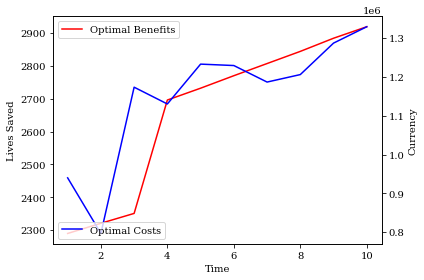

In [21]:
m.plot_time()


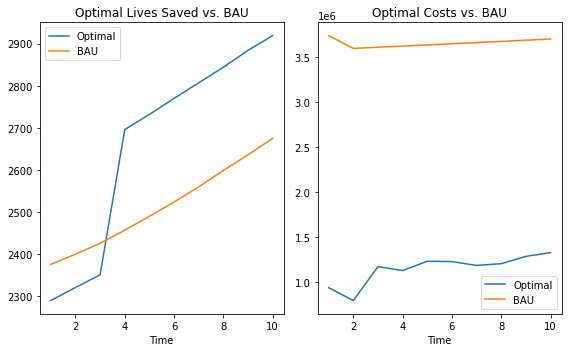

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize = (8,5))
m.plot_bau_time(ax=ax1)
m.plot_bau_time(opt_variable = 'c', ax=ax2)
plt.savefig("low_bau.png", dpi=600)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f434c90f040>)

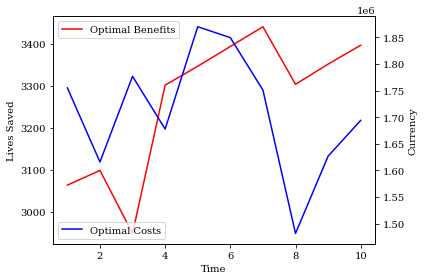

In [23]:
m_high.plot_time()

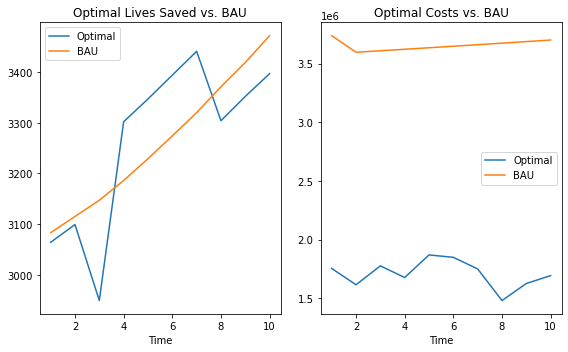

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,5))
m_high.plot_bau_time(ax=ax1)
m_high.plot_bau_time(opt_variable = 'c', ax=ax2)
plt.savefig("high_bau.png", dpi=600)

# word doc with graphs and tables
# email jsting about updated costs

### Mapping Lives Saved and Costs

In [25]:
# Load data
geo_df = gpd.read_file("examples/data/maps/cameroon/CAM.shp")

# Now we create the boundaries for North, South and Cities
# Based on "Measuring Costs of Vitamin A..., Table 2"
north = r"Adamaoua|Nord|Extreme-Nord"
south = r"Centre|Est|Nord-Ouest|Ouest|Sud|Sud-Ouest"
cities= r"Littoral" # Duala
# Yaounde is in Mfoundi
geo_df.loc[lambda df: df['ADM1'].str.contains(north), 'space'] = 'North'
geo_df.loc[lambda df: df['ADM1'].str.contains(south), 'space'] = 'South'
geo_df.loc[lambda df: df['ADM1'].str.contains(cities), 'space'] = 'Cities'
geo_df.loc[lambda df: df['ADM2'].str.contains(r"Mfoundi"), 'space'] = 'Cities'

# Now we aggregate the data to the `space` variable
agg_geo_df = geo_df.dissolve(by = 'space')


In [26]:
interact(m.plot_map_benchmark, 
intervention = fixed('oilzflourfcubefflour'), 
time = IntSlider(min=1, max=10, step=1, value=1), 
optimum_interest = ['b', 'c', 'cdb', 'cdc', 'cb', 'cc'], 
bench_intervention = fixed('oilvaszflourfflour33'),
map_df = fixed(agg_geo_df),
merge_key = fixed('space'),
save = fixed(None))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [27]:
interact(m_high.plot_map_benchmark, 
intervention = fixed(['maxoilcliniczflourfcubefflour','maxoilzflourfcubefflour']), 
time = IntSlider(min=1, max=10, step=1, value=1), 
optimum_interest = ['b', 'c', 'cdb', 'cdc', 'cb', 'cc'], 
bench_intervention = fixed('oilvaszflourfflour33'),
map_df = fixed(agg_geo_df),
merge_key = fixed('space'),
save = fixed(None))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## Trying Out a Different Constraint

Now instead of having the benefit constraint be some aggregate across space and time, let's make sure that the constraint is time-specific, as in the benefits of the optimal solution have to be at least as much in every time period.